# Corona Virus Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rawData = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")

In [3]:
dataFrames = dict(states={}, counties={})
columns = ['cases', 'deaths']

def getTotal(): 
    if not "total" in dataFrames:
        dataFrames["total"] =rawData.groupby('date').sum()[columns]
    return dataFrames["total"]

def getState(state):
    if not state in dataFrames["states"]:
        statedf = rawData[rawData.state==state].groupby('date').sum()[columns]
        if statedf.empty:
            print (state + " is not in the data, did you spell it right? capitalization?")
            return 
        else:
            dataFrames["states"][state] = statedf
    return dataFrames["states"][state]

def getCounty(county):
    if not county in dataFrames["counties"]:
        countydf = rawData[rawData.county==county].groupby('date').sum()[columns]
        if countydf.empty:
            print(county + " is not in the data, did you spell it right? capitalization?")
            return
        else:
            dataFrames["counties"][county] = countydf
    return dataFrames["counties"][county]
        

In [4]:
getTotal().tail(2) # last two dates data to check how recent this data is


cases  deaths
date                      
2020-04-05  336410    9661
2020-04-06  366363   10962

In [5]:
def fitExponential(series):
    series = series.dropna()
    series = series[series>0]
    logseries = np.log(series)
    n = len(logseries)
    rate, intercept = np.polyfit(np.arange(n), logseries, 1) 
    base = np.exp(intercept)
    return (rate, base, n) 


In [6]:
def plotFitted(series, name, log=True): 
    (rate, base, n) = fitExponential(series)
    x = np.arange(n)
    series = series[-n:]
    if log:
        plt.semilogy()
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    sbn.scatterplot(x, series, label=f"{name} actual")
    sbn.lineplot(x, base * np.exp(rate*x) , label=f"{name} expected with constant exponential growth")
    plt.show()

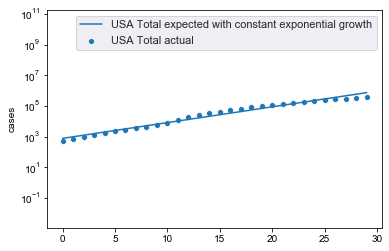

In [7]:
plotFitted(getTotal()["cases"][-30:], "USA Total")

In [8]:
def growthRateAnalysis(series, name, n=30):
    rate, base, n = fitExponential(series[-n:])
    name = f"{name} {series.name}"
    formula = f"{series.name} = {np.round(base, 2)} * exp({np.round(rate, 4)} * day)"
    dailyGrowth = np.round(100 * (np.exp(rate) - 1), 2)
    daysToDoubling = np.round(np.log(2)/rate, 2)
    print(f"{name} exponential formula fitted with {n} points:")
    print(formula)
    print(f"fitted daily growth rate: {dailyGrowth} %, fitted days to doubling: {daysToDoubling}")
    deltas = series.diff(1)
    rates = 100*deltas/series
    data = {
        f"{name} day to day growth rate (%)":rates, 
        f"{name} 3 day moving average":rates.rolling(window=3).mean(), 
        f"{name} 5 day moving average":rates.rolling(window=5).mean(), 
    }
    df = pd.DataFrame(data).dropna()[-n:]
    gr = df.tail(1)[f"{name} 5 day moving average"].values[0]
    dailyGrowth = np.round(gr, 2)
    daysToDoubling = np.round(np.log(2)*100/gr, 2)
    print(f"actual daily growth rate: {dailyGrowth} %, actual days to doubling: {daysToDoubling}")    
    sbn.lineplot(data=df)
    plt.show()
    plotFitted(series[-n:], name)


Total USA cases exponential formula fitted with 30 points:
cases = 783.57 * exp(0.2367 * day)
fitted daily growth rate: 26.71 %, fitted days to doubling: 2.93
actual daily growth rate: 10.1 %, actual days to doubling: 6.86


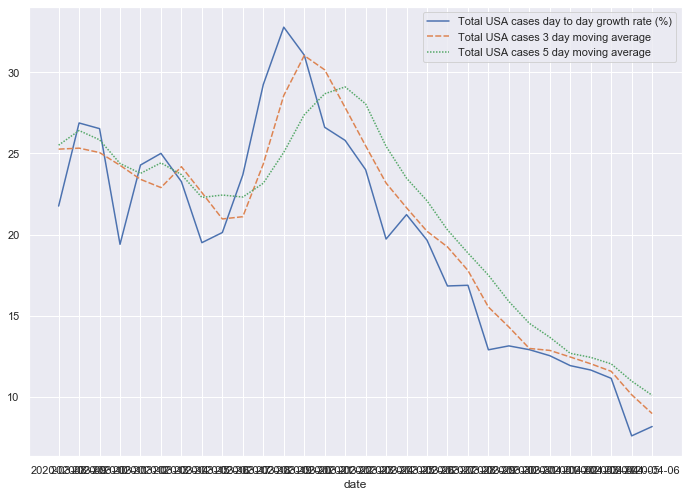

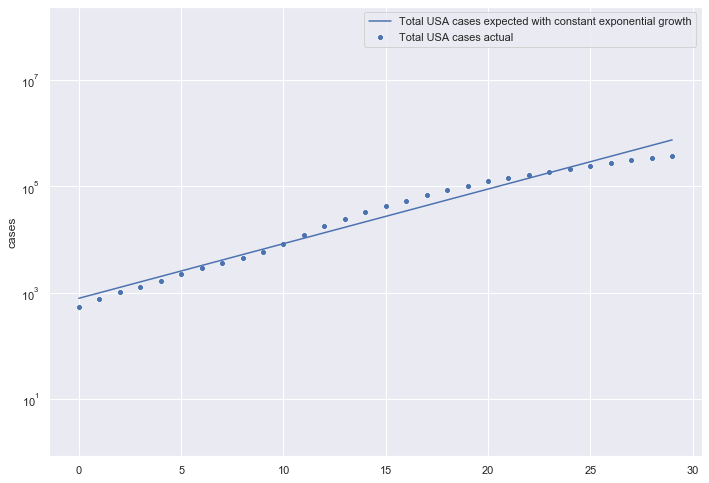

In [9]:
growthRateAnalysis(getTotal()['cases'], "Total USA")

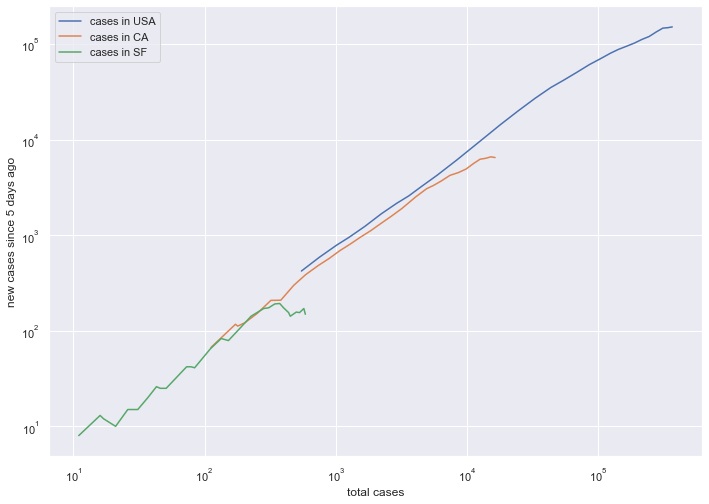

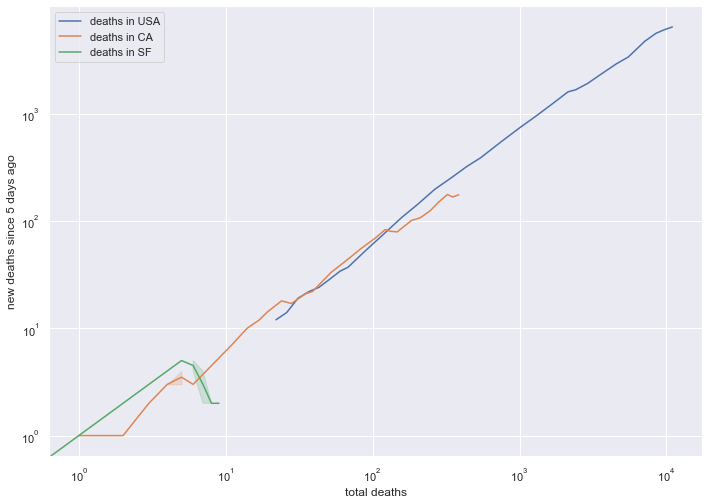

In [10]:
def trajectoryPlot(series, name):
    deltas = series.diff(5)
    fullname = f"{series.name} in {name}"
    x = f"total {series.name}"
    y = f"new {series.name} since 5 days ago"
    data = {x: series, y: deltas}
    plt.loglog()
    df = pd.DataFrame(data).dropna()[-30:]
    sbn.lineplot(x, y, data=df, label=fullname)
    
trajectoryPlot(getTotal()['cases'], "USA")
trajectoryPlot(getState("California")['cases'], "CA")
trajectoryPlot(getCounty("San Francisco")["cases"], "SF")
plt.show()
trajectoryPlot(getTotal()['deaths'], "USA")
trajectoryPlot(getState("California")['deaths'], "CA")
trajectoryPlot(getCounty("San Francisco")["deaths"], "SF")
plt.show()

In [11]:
def laggedPlot(df, name):
    vals = df.copy()
    vals = df.dropna()[df.cases > 0]
    # show correlation with wide range of time lags
    for i in range(30):
        vals[i] = df.cases.shift(i)
    vals = vals.drop(columns='cases')
    vals = vals[vals.deaths > 0][-20:]
    corrs = vals.corr()[['deaths']].drop('deaths')
    lc = np.log(vals).corr()[['deaths']].drop('deaths')
    lc[0] = lc.deaths
    for i in [3, 5, 7]:
        lc[i] = lc.deaths.rolling(i).mean()
    lc = lc.dropna()
    corrdata = {
        f"{name} correlation of log of deaths to log of cases by # of days ago": lc[0],
        f"{name} correlation 3 day moving average": lc[3],
        f"{name} correlation 5 day moving average": lc[5],
        f"{name} correlation 7 day moving average": lc[7],
    }
    corrsdf = pd.DataFrame(corrdata)
    print(f"Correlations for {name}:")
    sbn.lineplot(data=corrsdf)
    plt.show()
    # dig deeper into an interesting set of time lags
    values = vals[["deaths"]].copy()
    ratios = vals[["deaths"]].copy()
    interesting = [7, 14]
    for i in [0, 3, 5, 7]:
        l = lc[i].dropna()
        lmax = l[l==max(l)] # max at this correlation moving average
        interesting += list(lmax.index)
    for i in sorted(list(set(interesting))):
        values[f"{name} cases {i} days ago"] = vals[i]
        ratios[f"{name} deaths/cases {i} days ago"] = vals.deaths/vals[i]
    ratios = ratios.drop(columns=['deaths'])
    print(f"Deaths vs Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=values, dashes=False)
    plt.show()
    print(f"Deaths / Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=ratios, dashes=False)
    plt.show()

    

Correlations for USA:


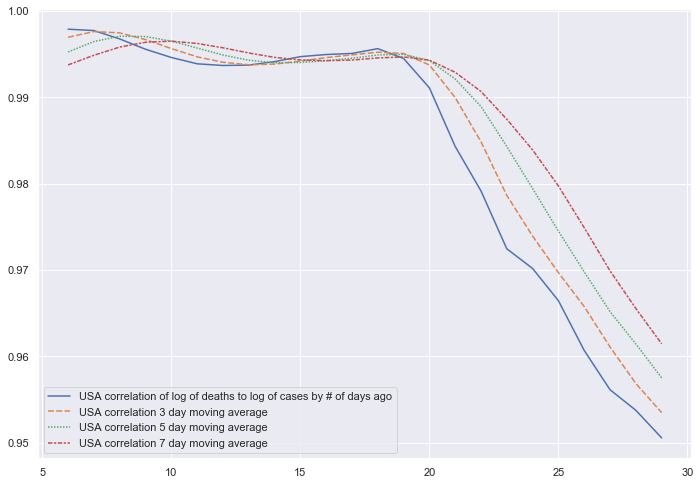

Deaths vs Lagged Values For USA:


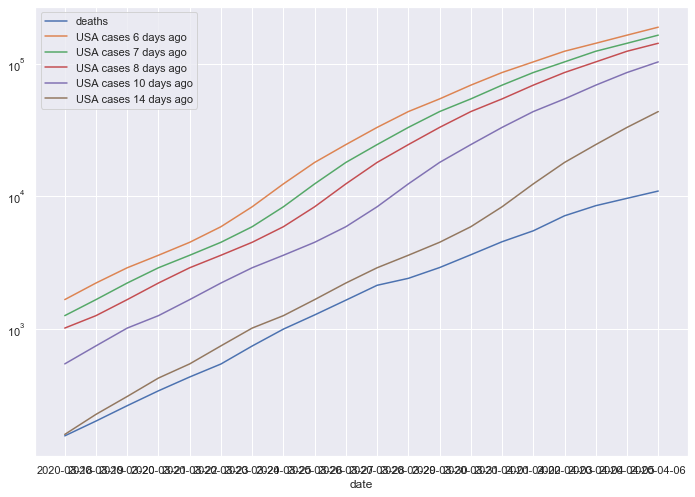

Deaths / Lagged Values For USA:


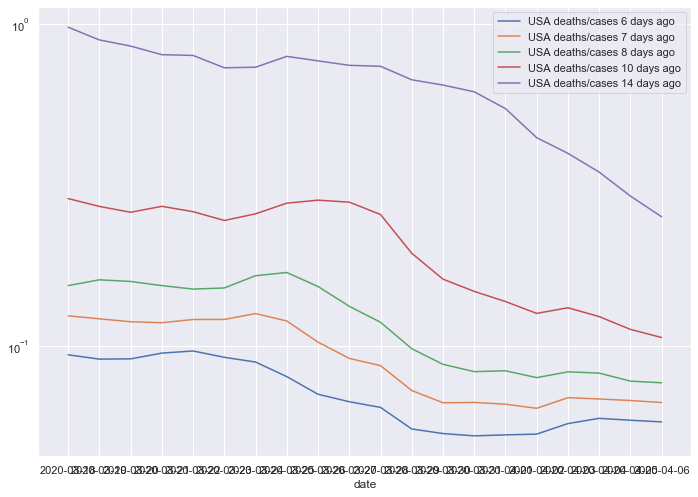

Correlations for CA:


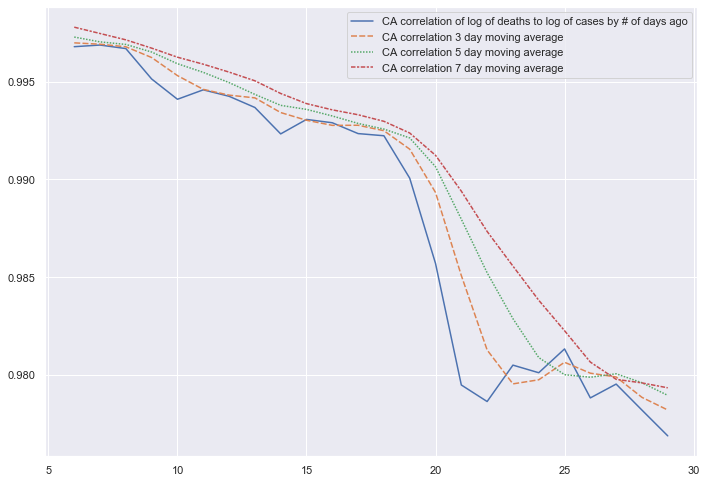

Deaths vs Lagged Values For CA:


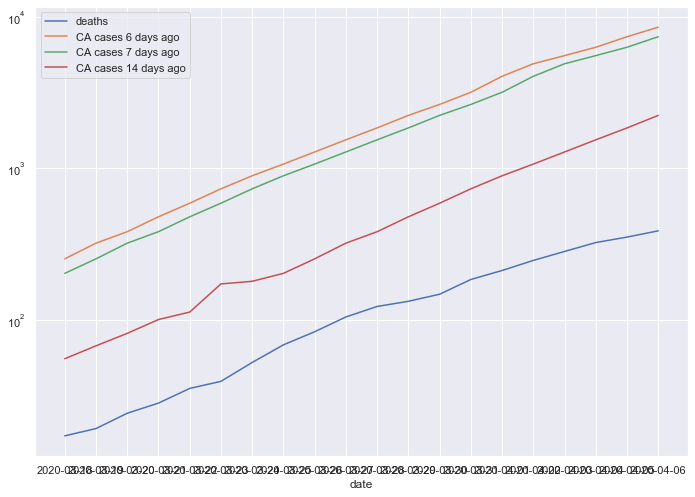

Deaths / Lagged Values For CA:


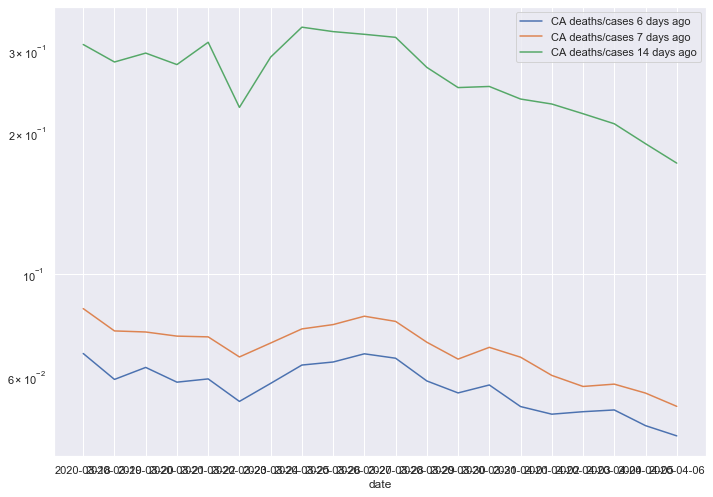

Correlations for SF:


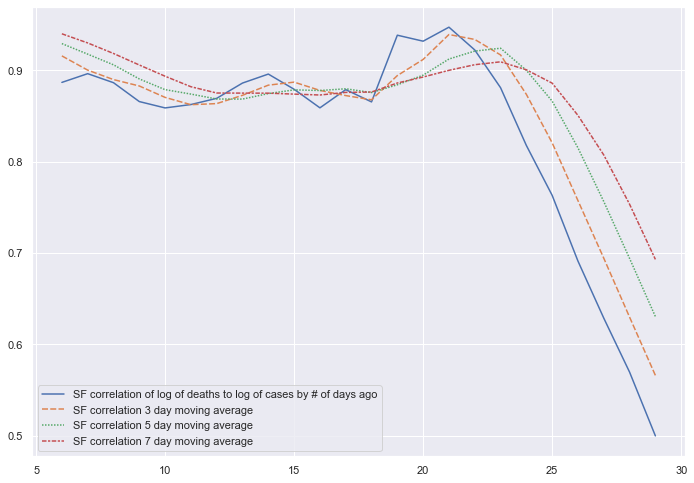

Deaths vs Lagged Values For SF:


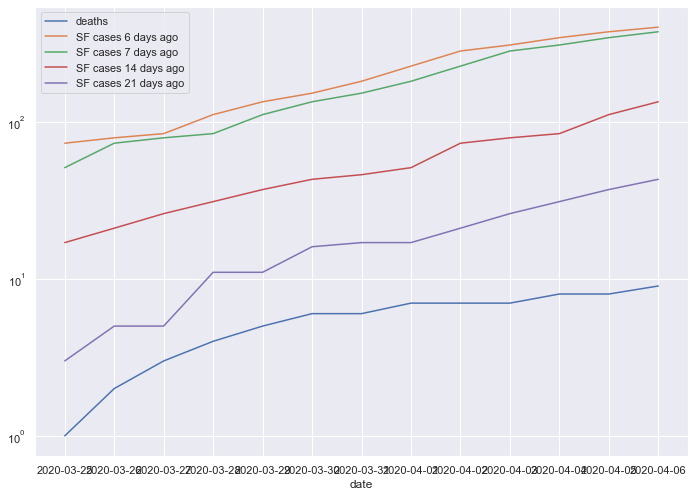

Deaths / Lagged Values For SF:


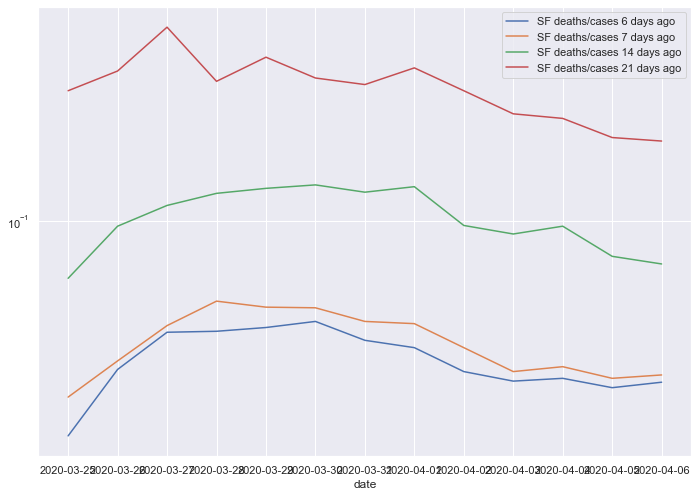

In [12]:
laggedPlot(getTotal(), "USA")
laggedPlot(getState("California"), "CA")
laggedPlot(getCounty("San Francisco"), "SF")

In [13]:
def analyse(counties=[], states=[], n=20):
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    names = counties + states + ["USA total:"]
    rates= []
    dfs = [getCounty(c) for c in counties] + [getState(s) for s in states] + [getTotal()] 
    print("Trajectory Plots to see if the curve is flattening:")
    for col in ["cases", "deaths"]:
        for df, name in zip(dfs, names):
            trajectoryPlot(df[col], name)
        plt.show()
    for df, name in zip(dfs, names):
        print(f"\n### Analysis for {name:} ###\n")
        growthRateAnalysis(df["cases"], name)
        growthRateAnalysis(df["deaths"], name)
        print(f"Trajectory plots for {name}, to see when the curve starts flattening")
        trajectoryPlot(df.cases, name)
        trajectoryPlot(df.deaths, name)
        plt.show()
        laggedPlot(df, name)


        
    
    

Trajectory Plots to see if the curve is flattening:


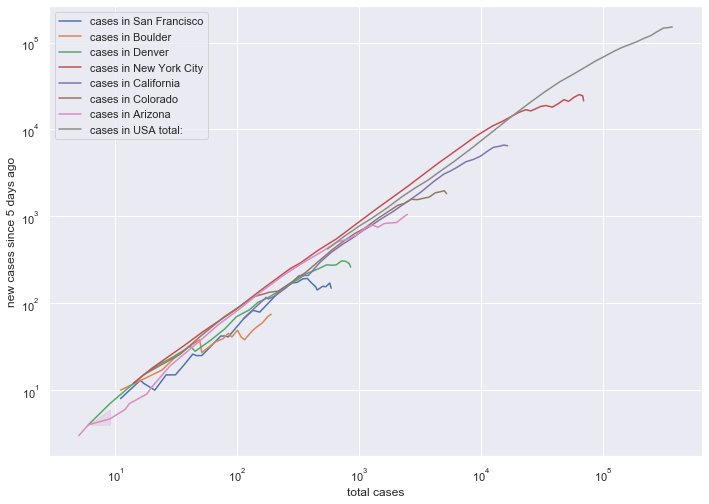

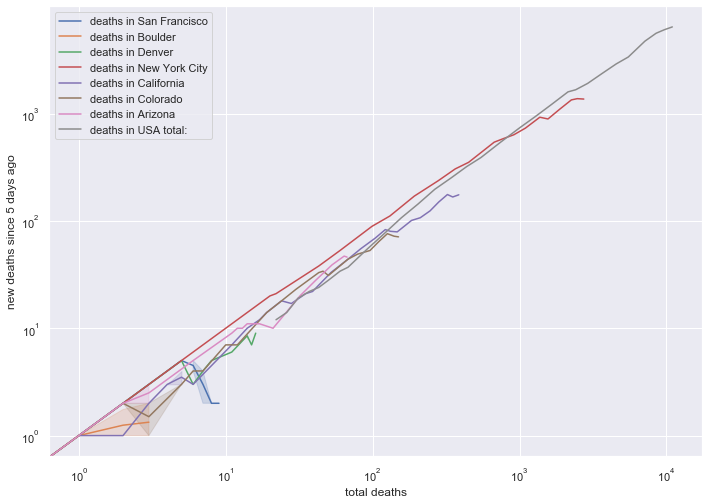


### Analysis for San Francisco ###

San Francisco cases exponential formula fitted with 30 points:
cases = 13.36 * exp(0.1444 * day)
fitted daily growth rate: 15.53 %, fitted days to doubling: 4.8
actual daily growth rate: 5.66 %, actual days to doubling: 12.25


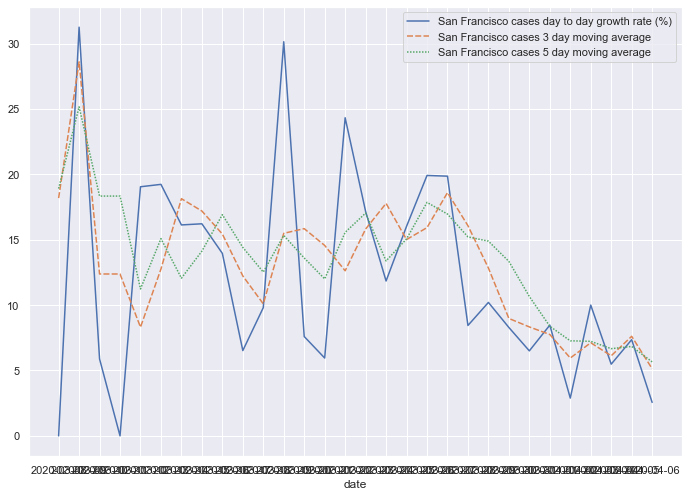

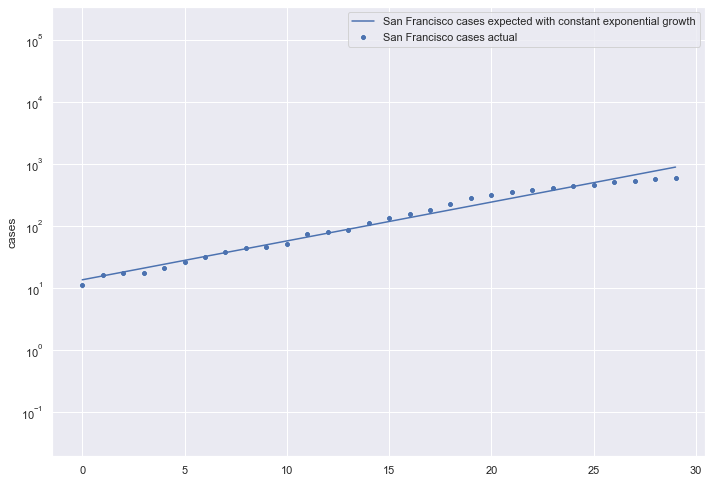

San Francisco deaths exponential formula fitted with 13 points:
deaths = 2.03 * exp(0.1458 * day)
fitted daily growth rate: 15.7 %, fitted days to doubling: 4.75
actual daily growth rate: 4.72 %, actual days to doubling: 14.68


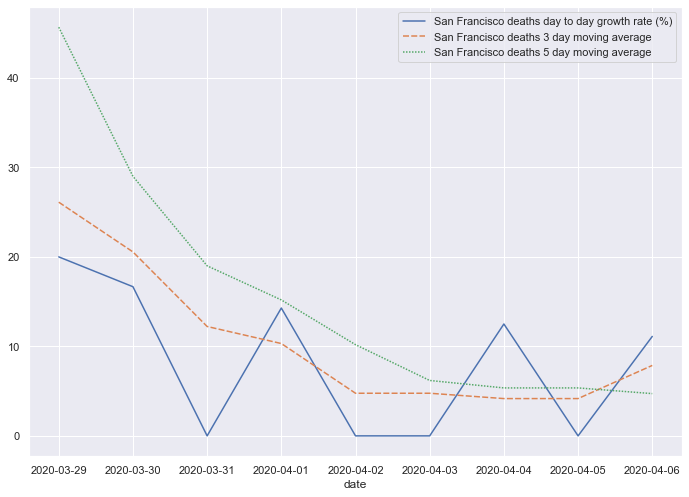

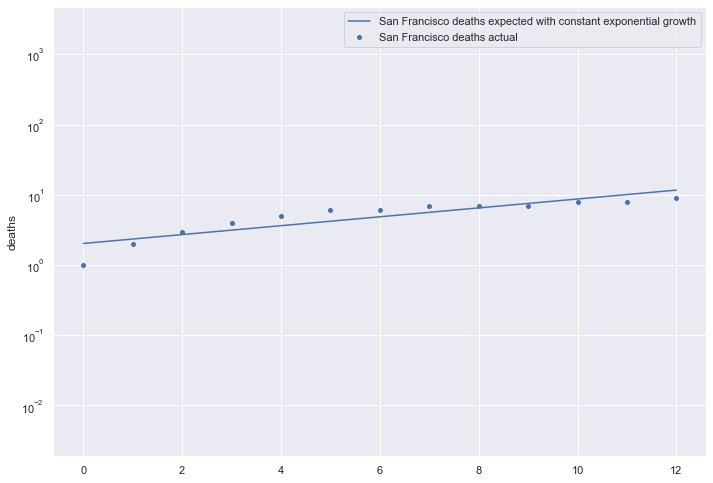

Trajectory plots for San Francisco, to see when the curve starts flattening


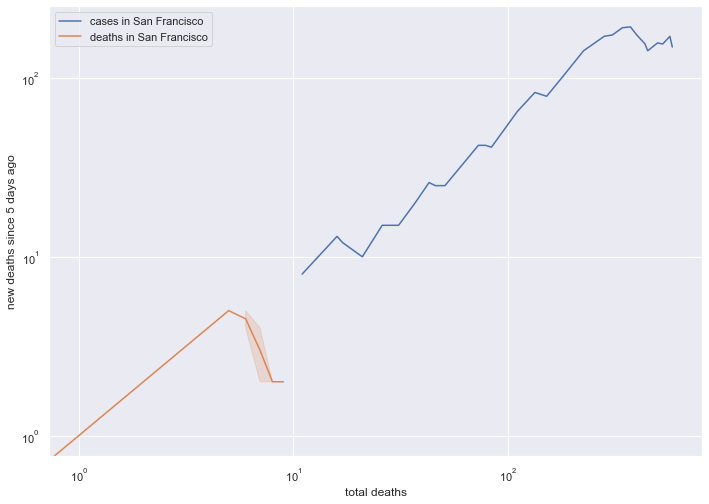

Correlations for San Francisco:


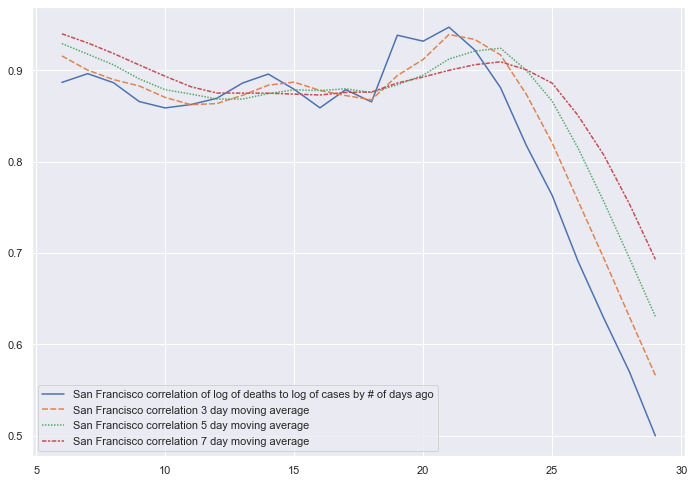

Deaths vs Lagged Values For San Francisco:


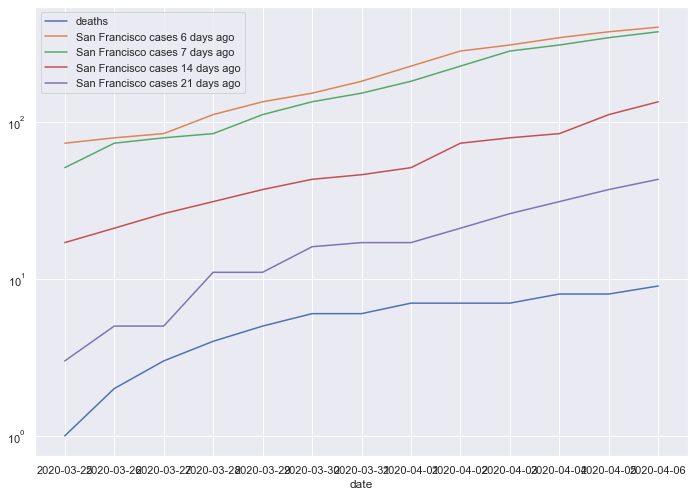

Deaths / Lagged Values For San Francisco:


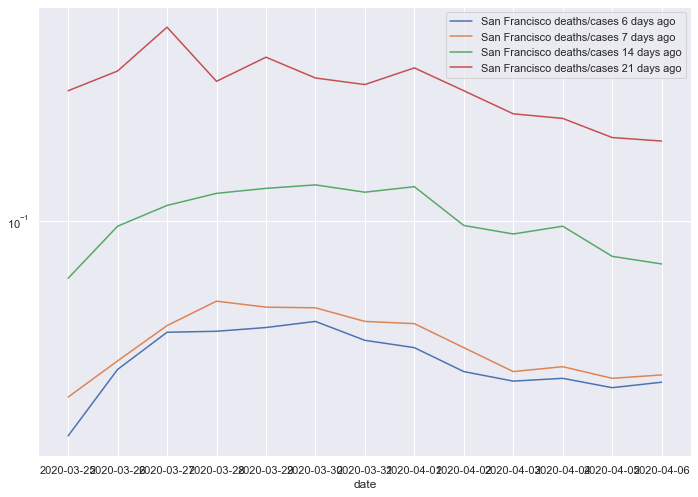


### Analysis for Boulder ###

Boulder cases exponential formula fitted with 24 points:
cases = 5.28 * exp(0.1774 * day)
fitted daily growth rate: 19.42 %, fitted days to doubling: 3.91
actual daily growth rate: 9.58 %, actual days to doubling: 7.23


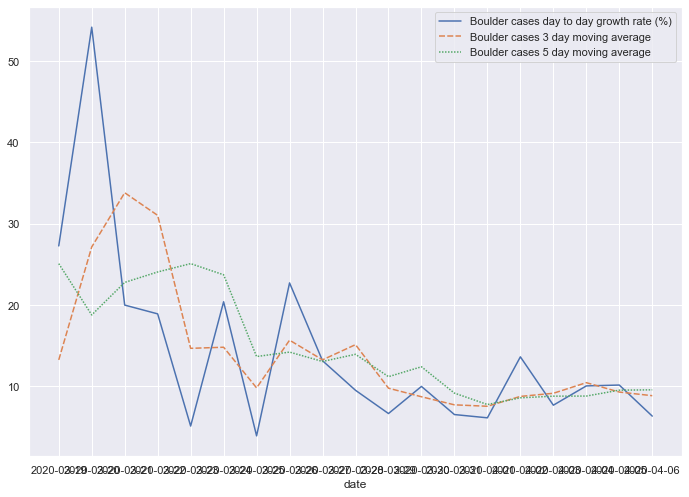

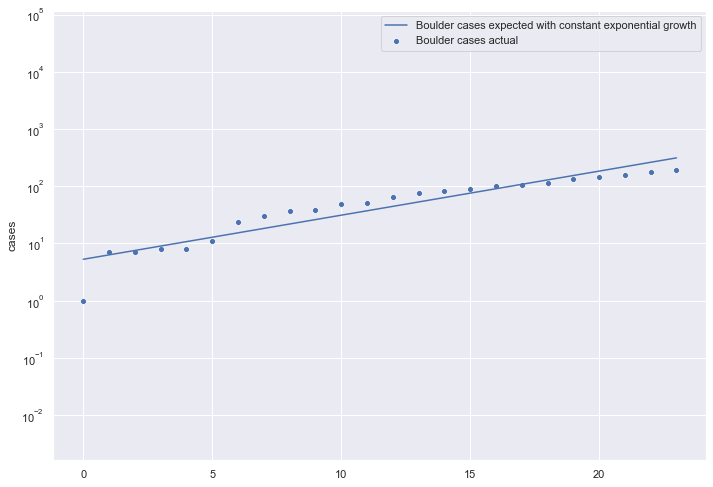

Boulder deaths exponential formula fitted with 11 points:
deaths = 0.9 * exp(0.1325 * day)
fitted daily growth rate: 14.16 %, fitted days to doubling: 5.23
actual daily growth rate: 6.67 %, actual days to doubling: 10.4


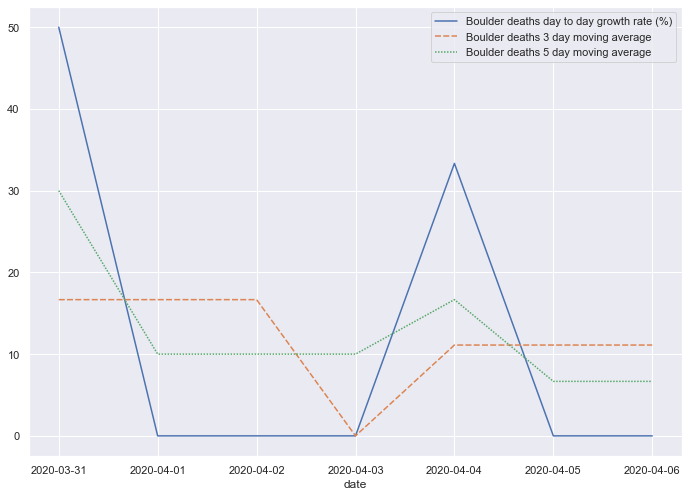

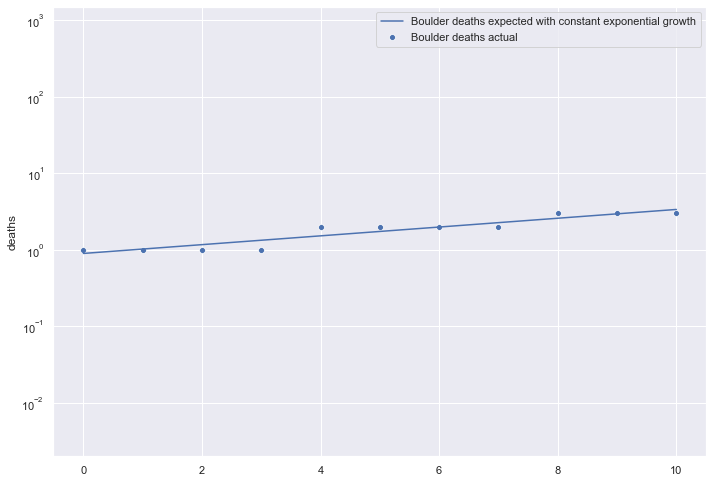

Trajectory plots for Boulder, to see when the curve starts flattening


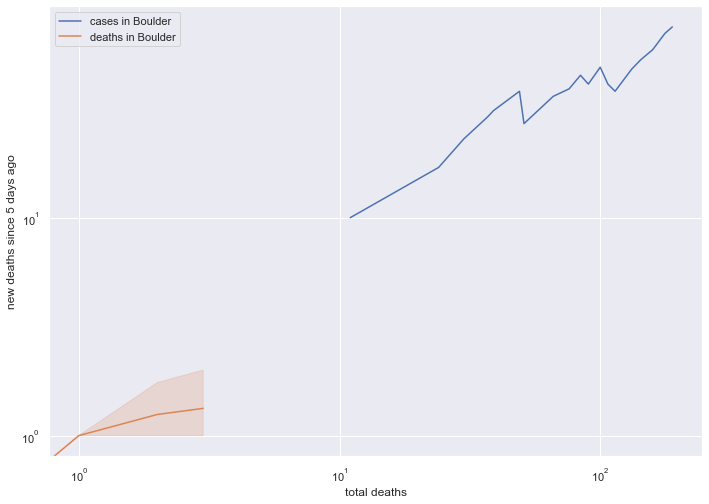

Correlations for Boulder:


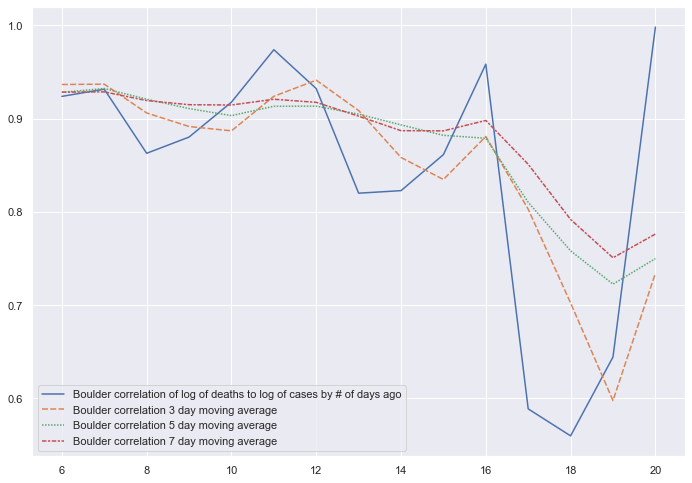

Deaths vs Lagged Values For Boulder:


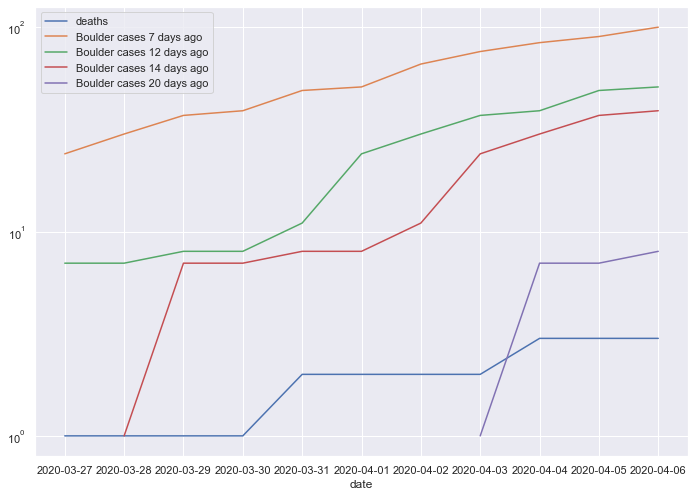

Deaths / Lagged Values For Boulder:


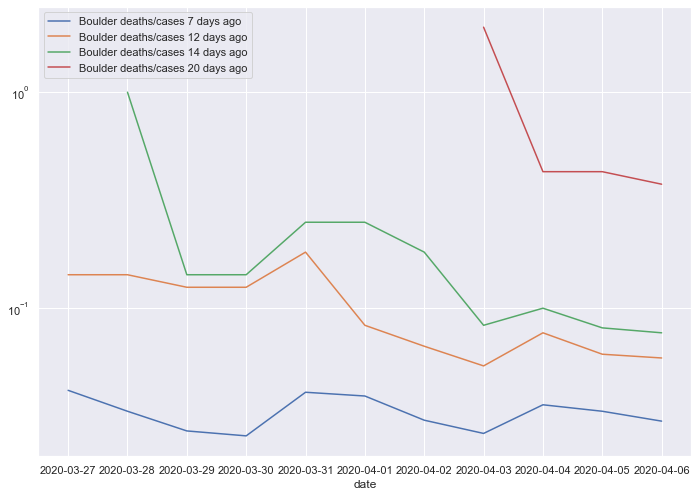


### Analysis for Denver ###

Denver cases exponential formula fitted with 30 points:
cases = 4.86 * exp(0.2035 * day)
fitted daily growth rate: 22.57 %, fitted days to doubling: 3.41
actual daily growth rate: 7.07 %, actual days to doubling: 9.81


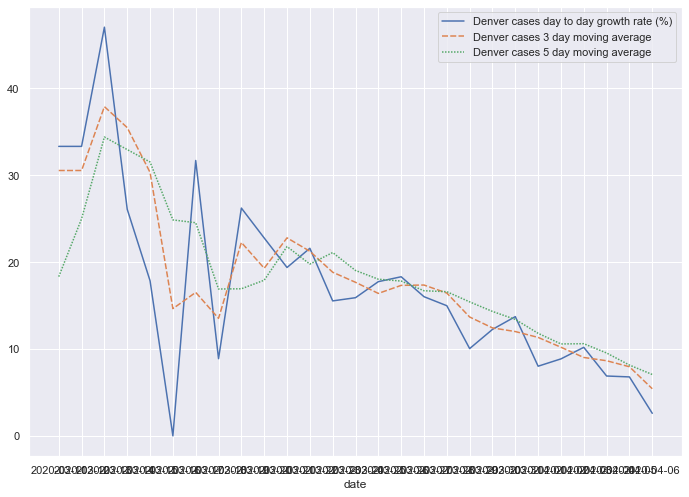

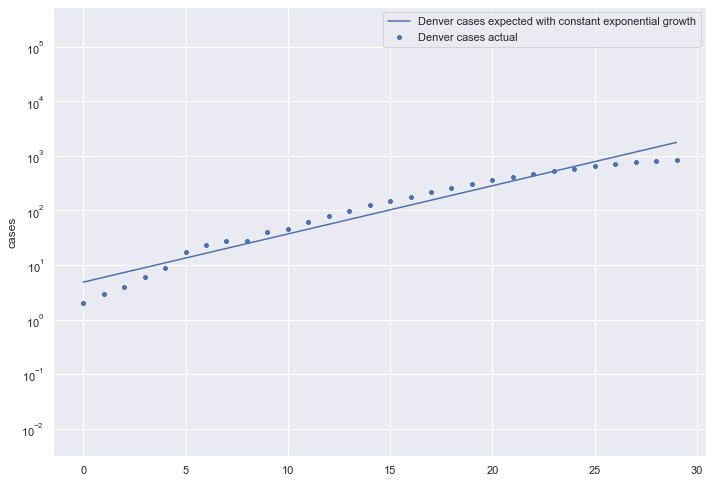

Denver deaths exponential formula fitted with 13 points:
deaths = 2.72 * exp(0.1601 * day)
fitted daily growth rate: 17.37 %, fitted days to doubling: 4.33
actual daily growth rate: 10.91 %, actual days to doubling: 6.36


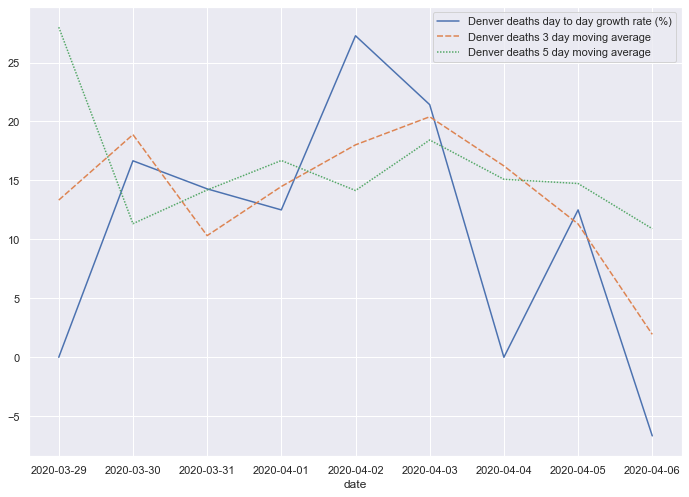

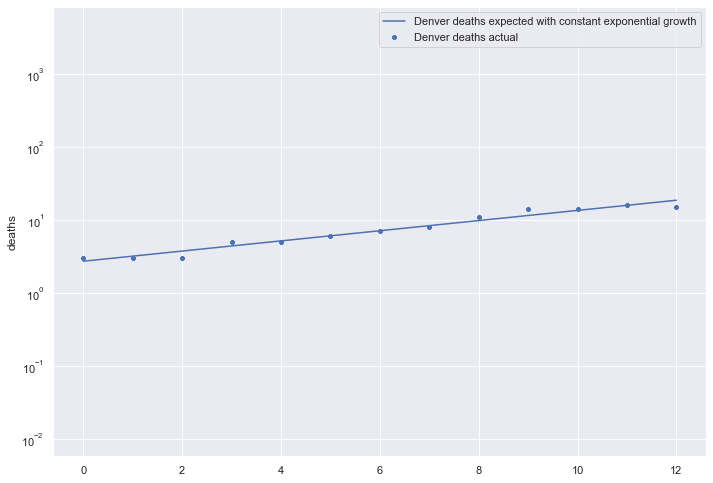

Trajectory plots for Denver, to see when the curve starts flattening


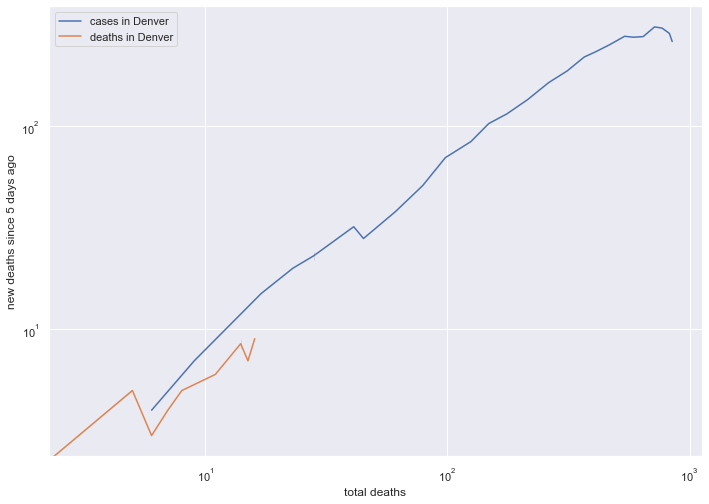

Correlations for Denver:


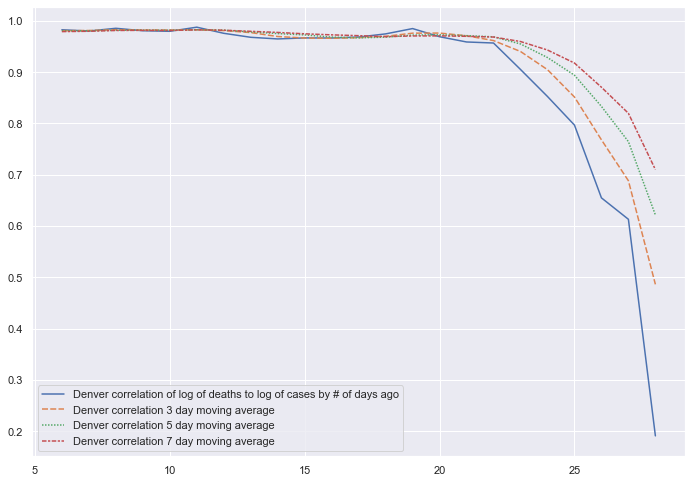

Deaths vs Lagged Values For Denver:


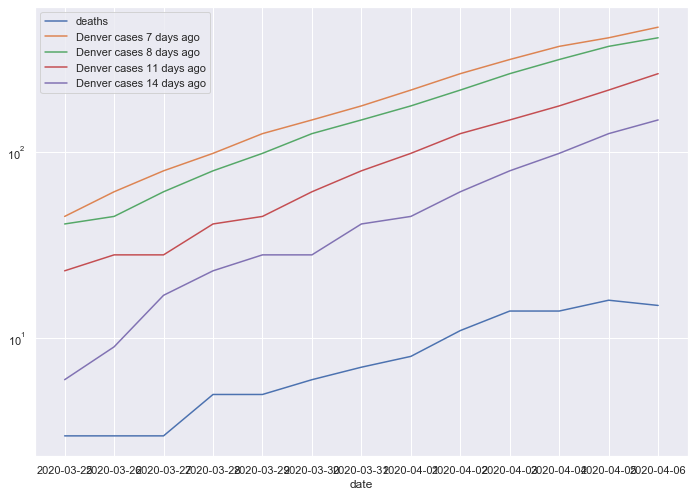

Deaths / Lagged Values For Denver:


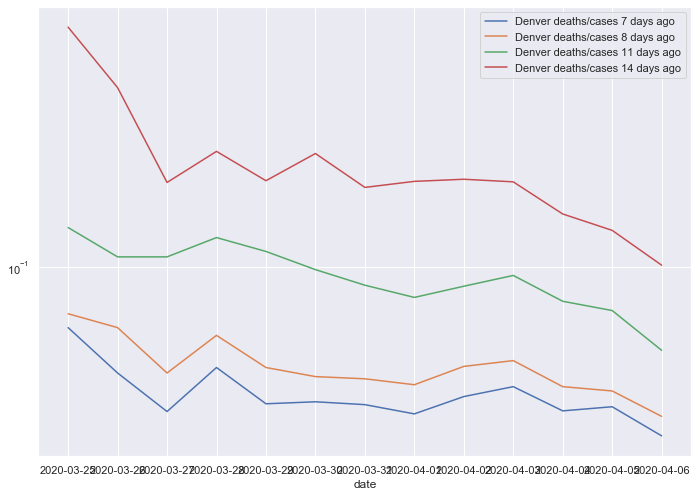


### Analysis for New York City ###

New York City cases exponential formula fitted with 30 points:
cases = 43.54 * exp(0.3031 * day)
fitted daily growth rate: 35.4 %, fitted days to doubling: 2.29
actual daily growth rate: 7.11 %, actual days to doubling: 9.74


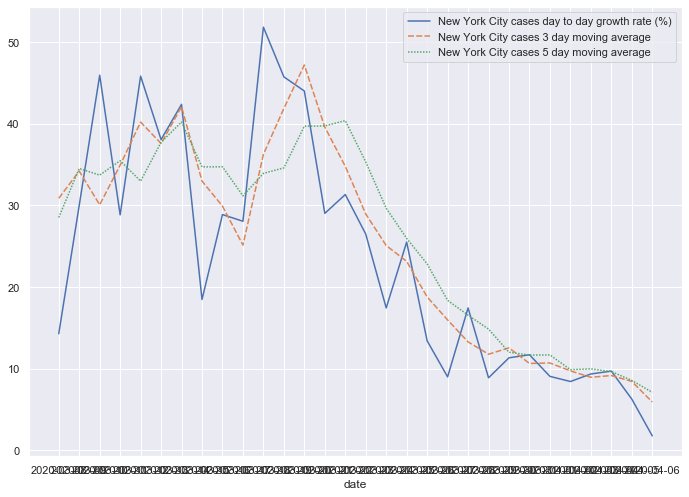

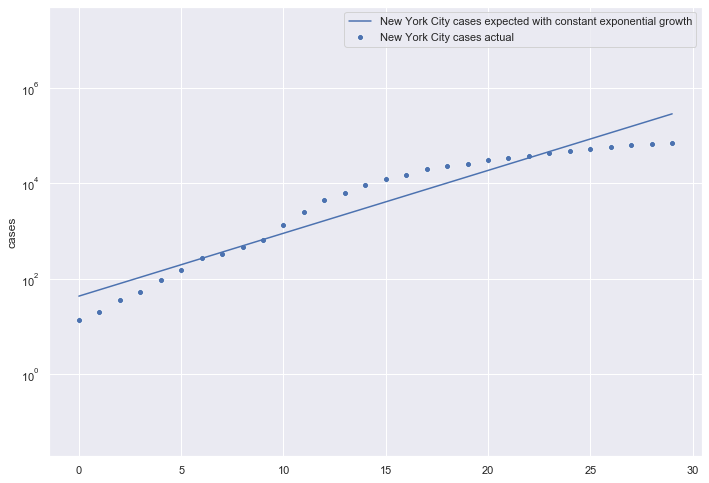

New York City deaths exponential formula fitted with 24 points:
deaths = 5.05 * exp(0.3111 * day)
fitted daily growth rate: 36.5 %, fitted days to doubling: 2.23
actual daily growth rate: 12.82 %, actual days to doubling: 5.41


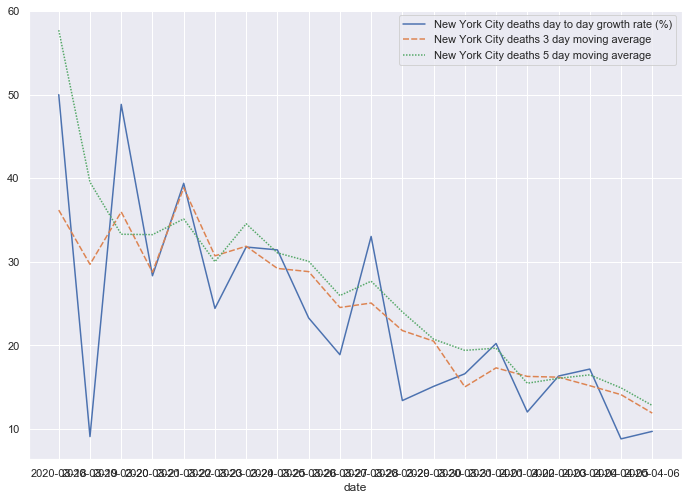

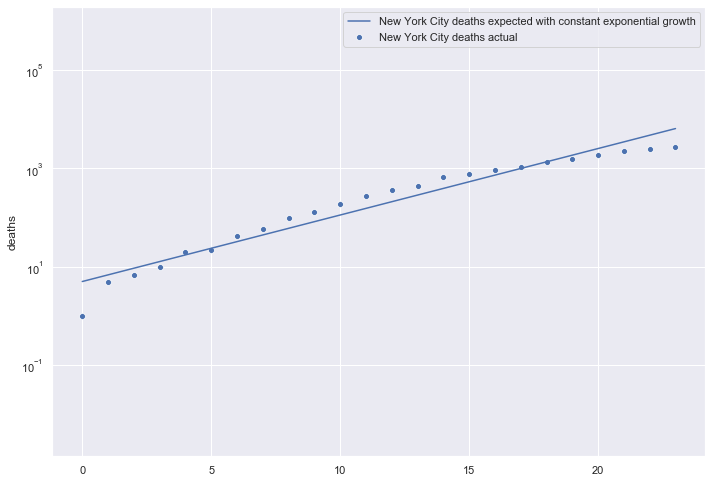

Trajectory plots for New York City, to see when the curve starts flattening


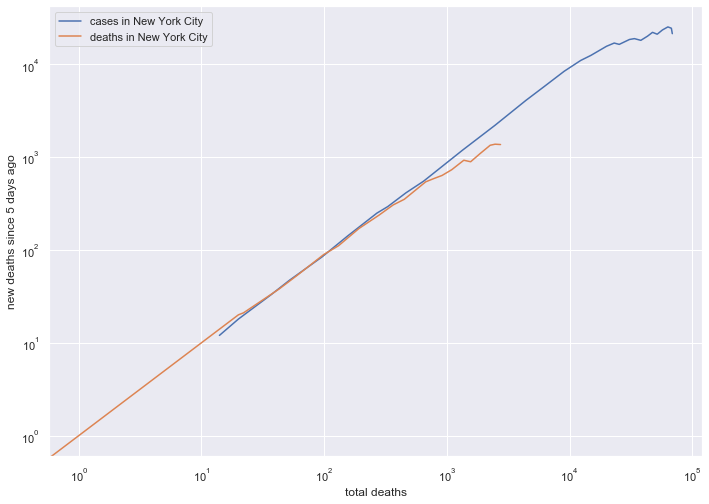

Correlations for New York City:


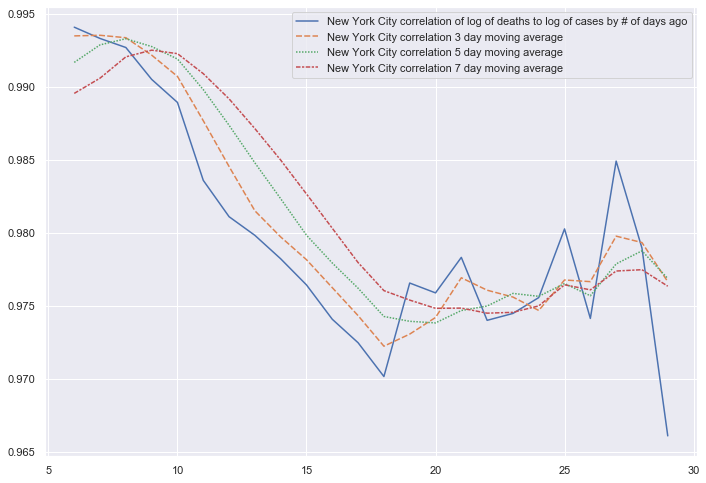

Deaths vs Lagged Values For New York City:


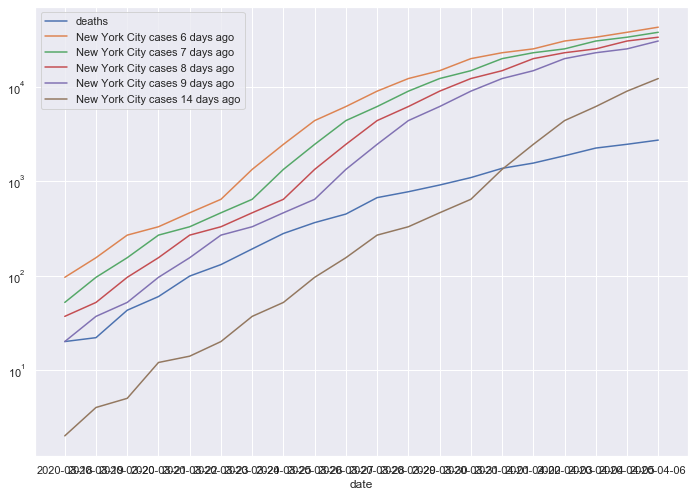

Deaths / Lagged Values For New York City:


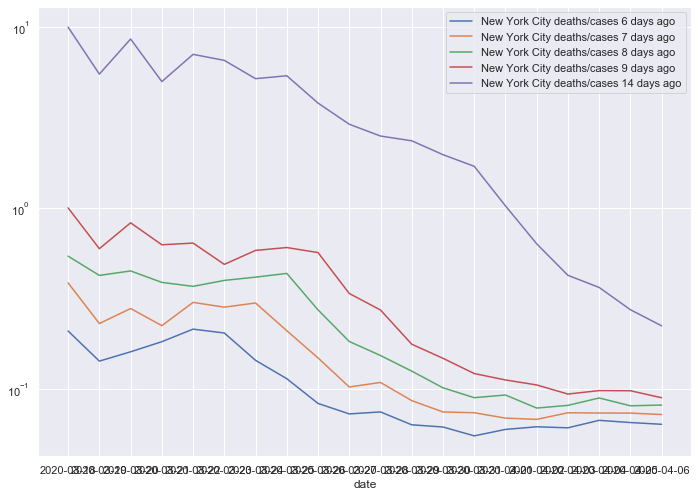


### Analysis for California ###

California cases exponential formula fitted with 30 points:
cases = 141.17 * exp(0.1763 * day)
fitted daily growth rate: 19.28 %, fitted days to doubling: 3.93
actual daily growth rate: 9.62 %, actual days to doubling: 7.21


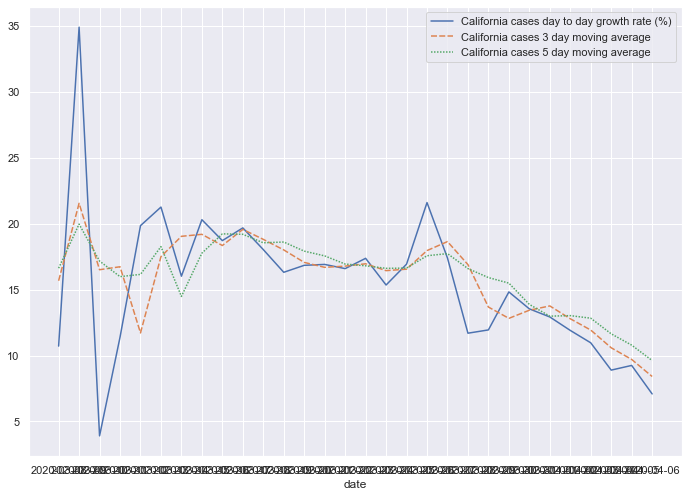

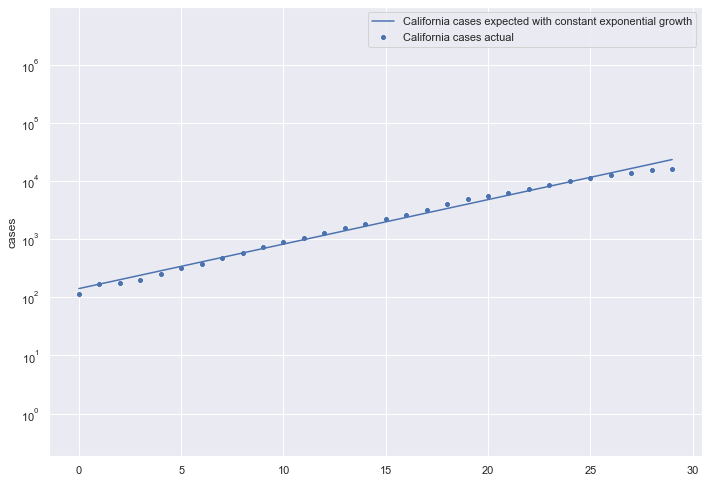

California deaths exponential formula fitted with 30 points:
deaths = 1.93 * exp(0.1966 * day)
fitted daily growth rate: 21.73 %, fitted days to doubling: 3.52
actual daily growth rate: 11.35 %, actual days to doubling: 6.11


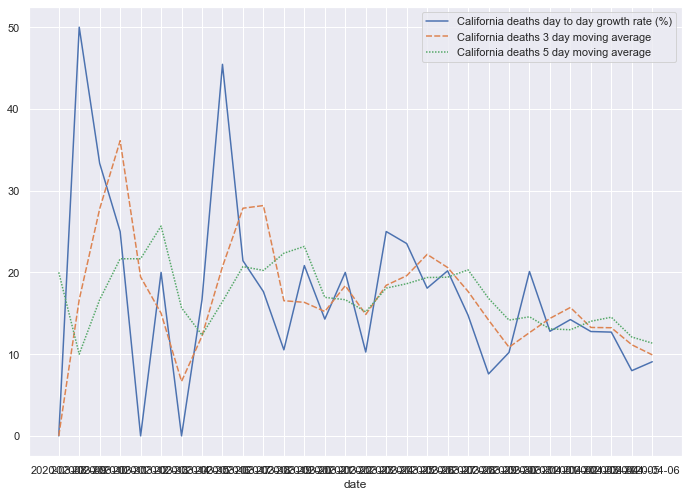

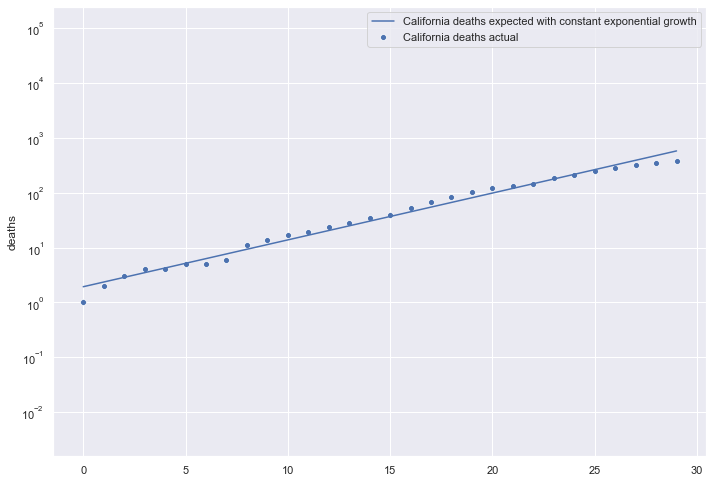

Trajectory plots for California, to see when the curve starts flattening


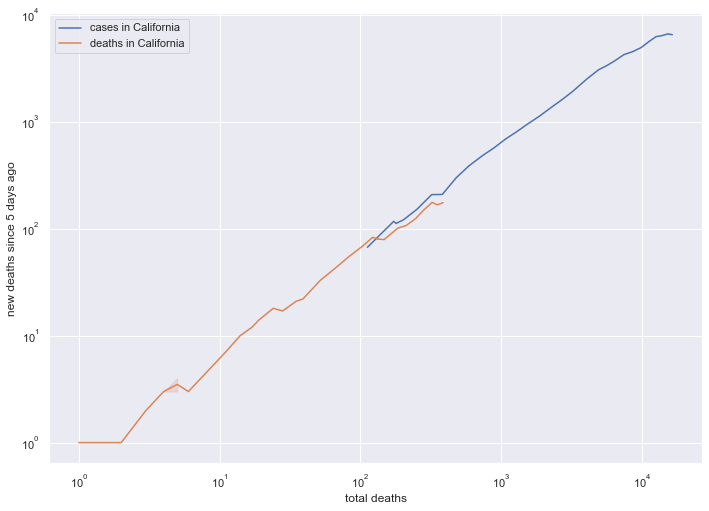

Correlations for California:


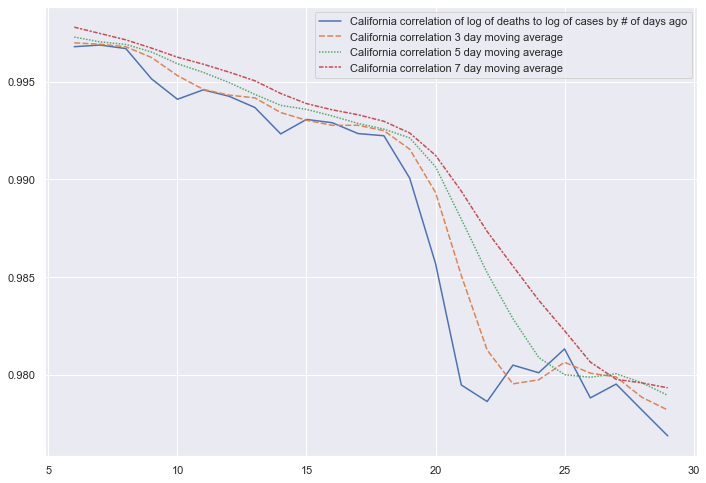

Deaths vs Lagged Values For California:


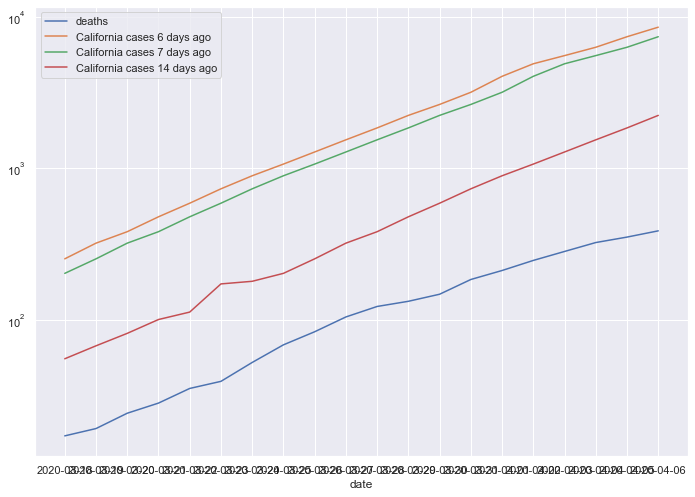

Deaths / Lagged Values For California:


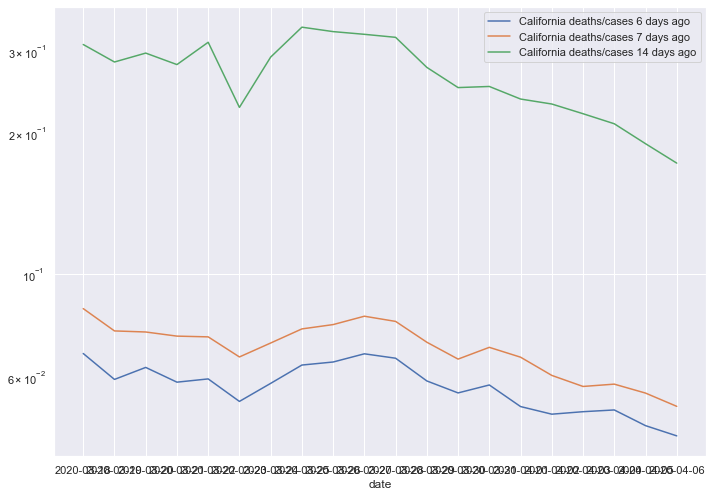


### Analysis for Colorado ###

Colorado cases exponential formula fitted with 30 points:
cases = 21.24 * exp(0.2145 * day)
fitted daily growth rate: 23.93 %, fitted days to doubling: 3.23
actual daily growth rate: 8.3 %, actual days to doubling: 8.35


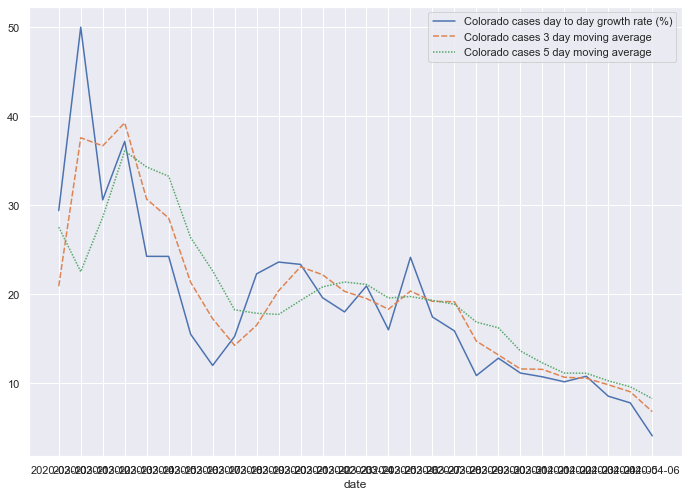

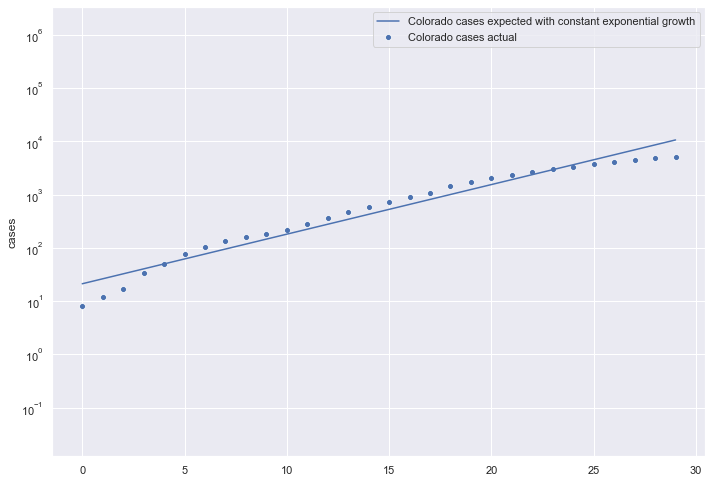

Colorado deaths exponential formula fitted with 26 points:
deaths = 1.1 * exp(0.2089 * day)
fitted daily growth rate: 23.23 %, fitted days to doubling: 3.32
actual daily growth rate: 11.96 %, actual days to doubling: 5.8


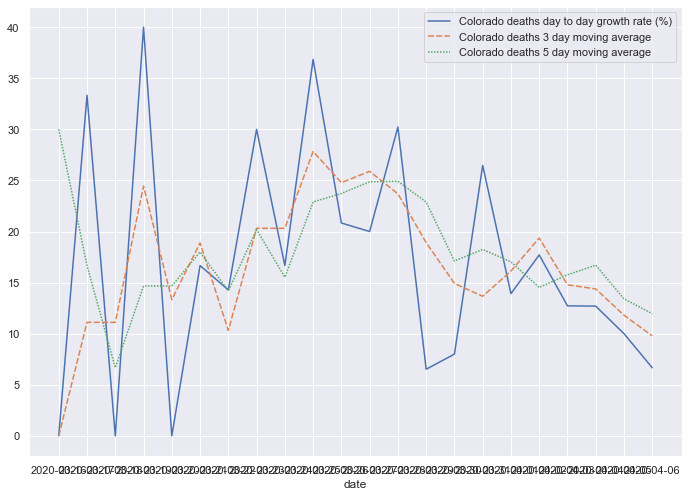

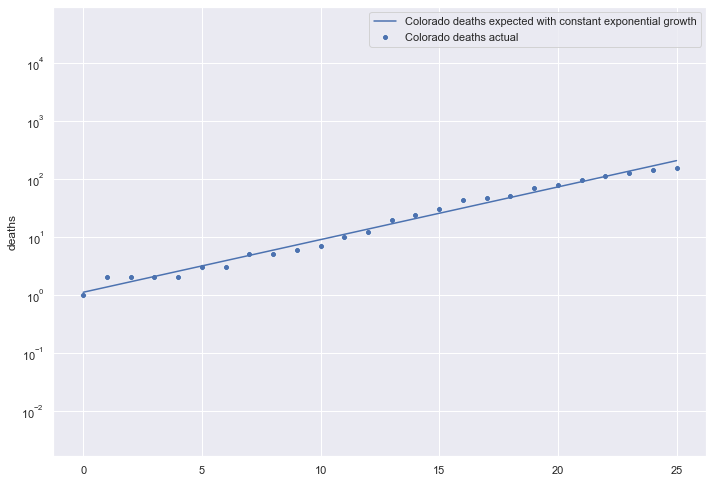

Trajectory plots for Colorado, to see when the curve starts flattening


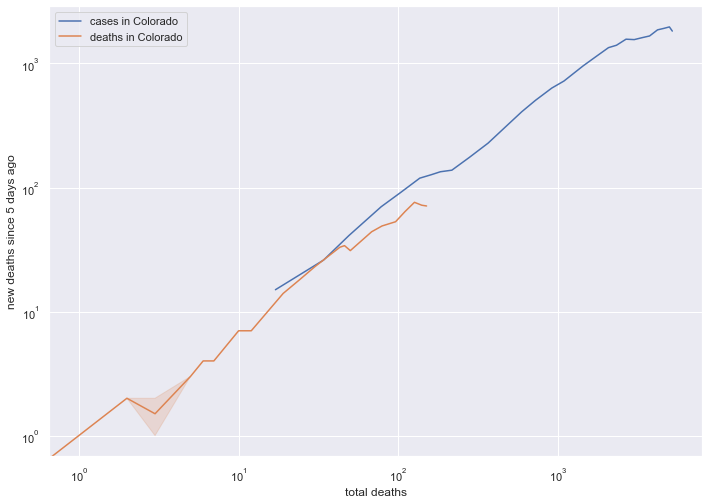

Correlations for Colorado:


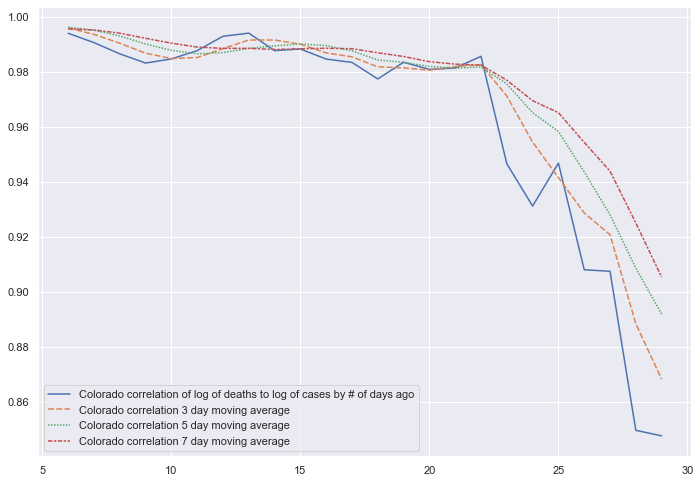

Deaths vs Lagged Values For Colorado:


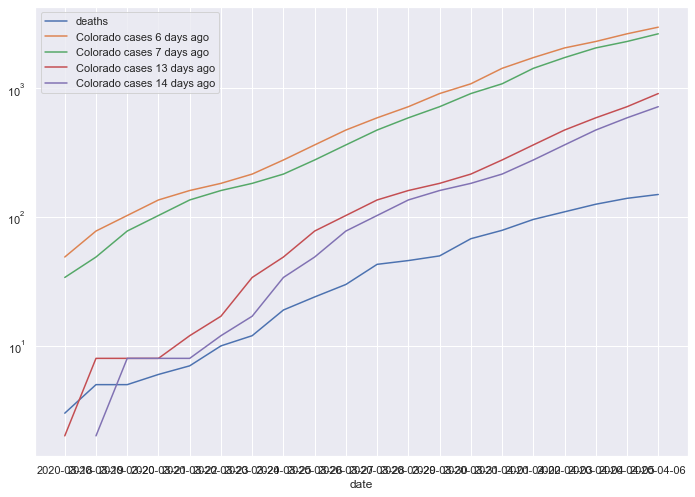

Deaths / Lagged Values For Colorado:


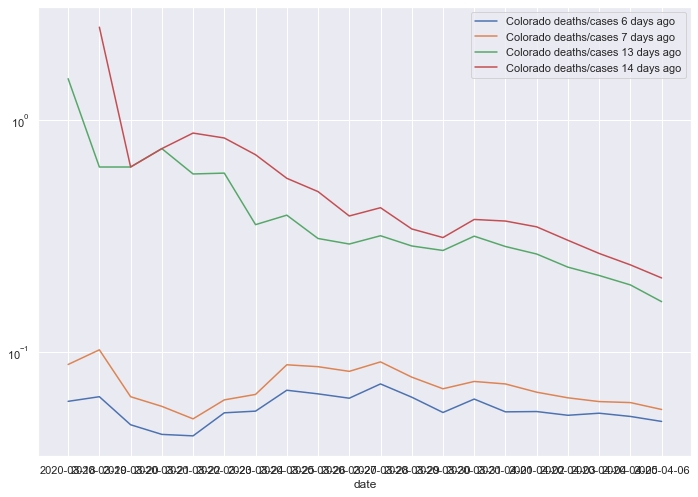


### Analysis for Arizona ###

Arizona cases exponential formula fitted with 30 points:
cases = 3.73 * exp(0.2465 * day)
fitted daily growth rate: 27.96 %, fitted days to doubling: 2.81
actual daily growth rate: 10.53 %, actual days to doubling: 6.59


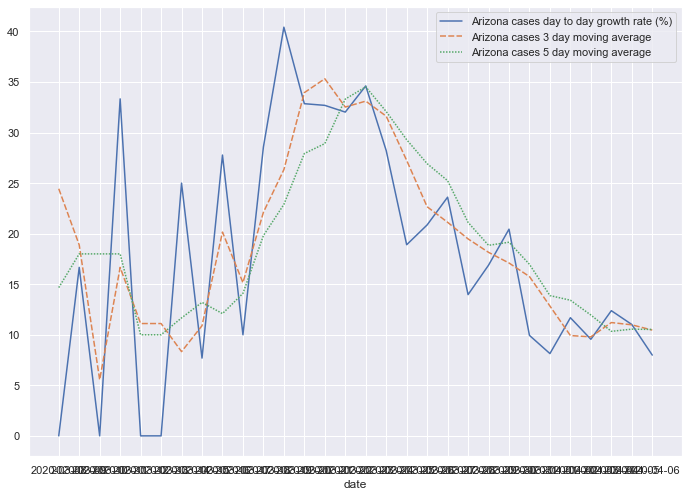

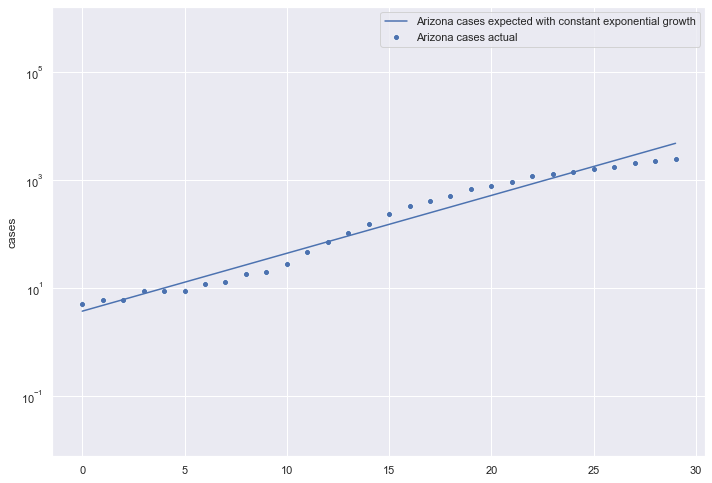

Arizona deaths exponential formula fitted with 18 points:
deaths = 1.07 * exp(0.2586 * day)
fitted daily growth rate: 29.52 %, fitted days to doubling: 2.68
actual daily growth rate: 20.13 %, actual days to doubling: 3.44


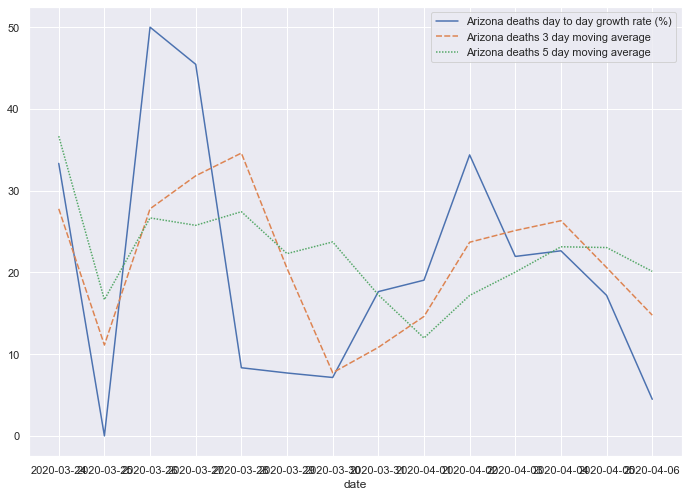

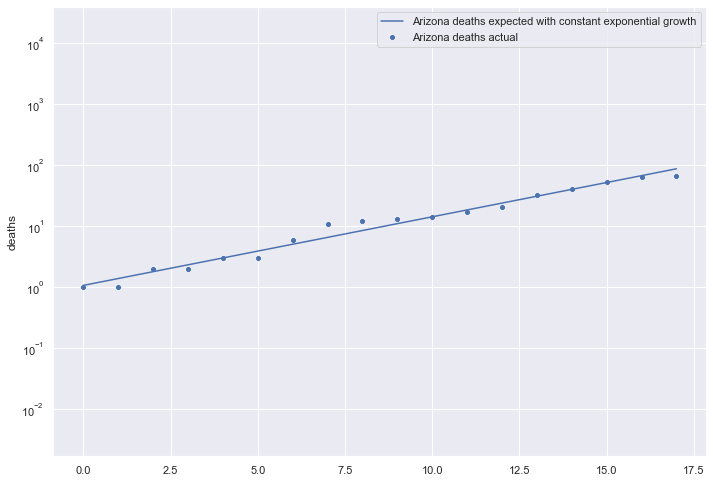

Trajectory plots for Arizona, to see when the curve starts flattening


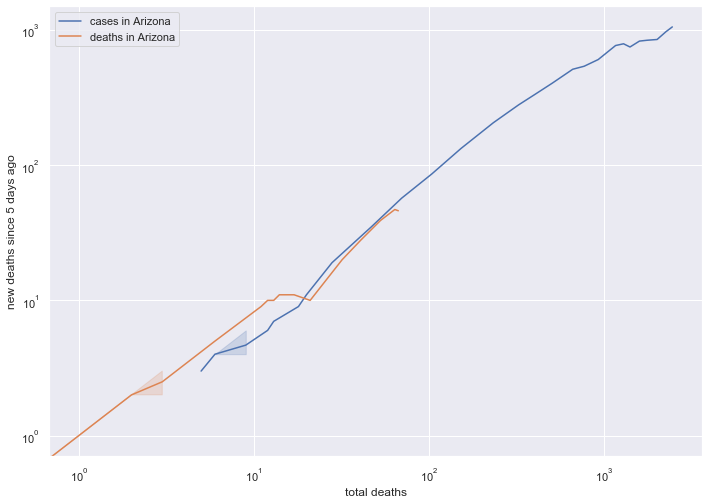

Correlations for Arizona:


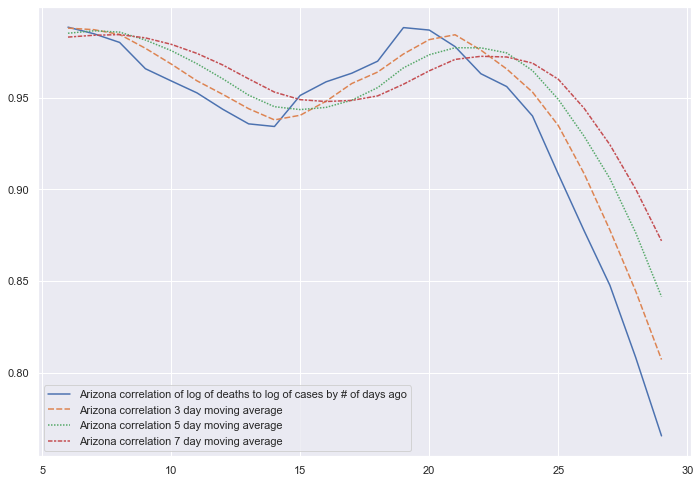

Deaths vs Lagged Values For Arizona:


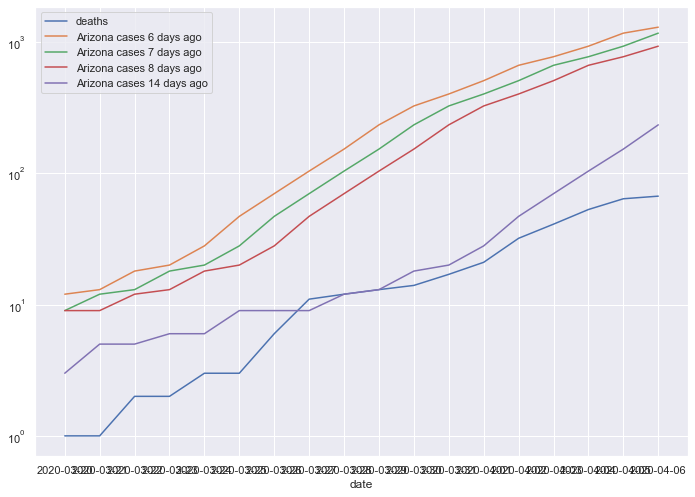

Deaths / Lagged Values For Arizona:


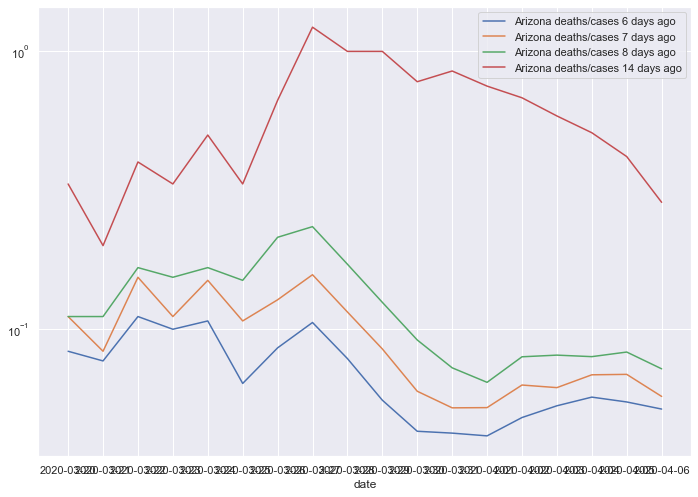


### Analysis for USA total: ###

USA total: cases exponential formula fitted with 30 points:
cases = 783.57 * exp(0.2367 * day)
fitted daily growth rate: 26.71 %, fitted days to doubling: 2.93
actual daily growth rate: 10.1 %, actual days to doubling: 6.86


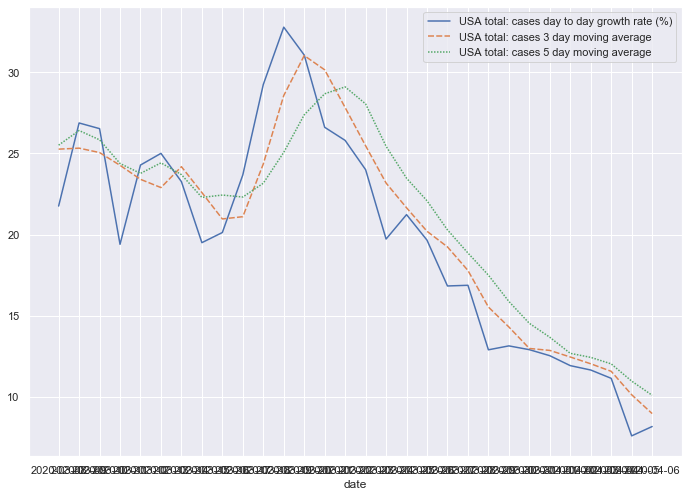

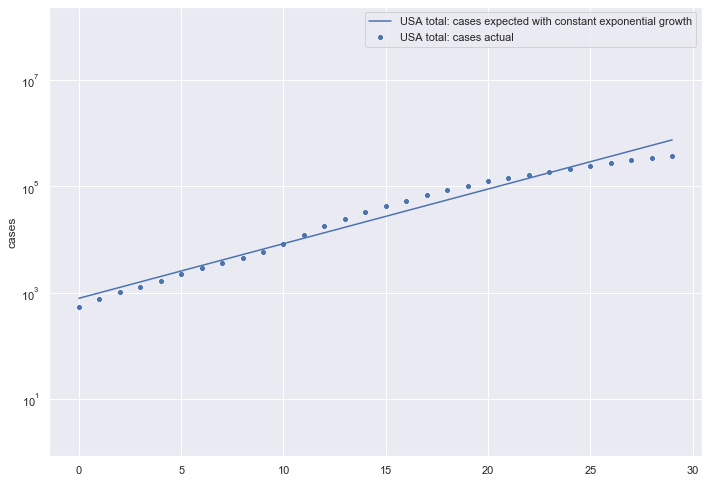

USA total: deaths exponential formula fitted with 30 points:
deaths = 17.58 * exp(0.2298 * day)
fitted daily growth rate: 25.83 %, fitted days to doubling: 3.02
actual daily growth rate: 16.02 %, actual days to doubling: 4.33


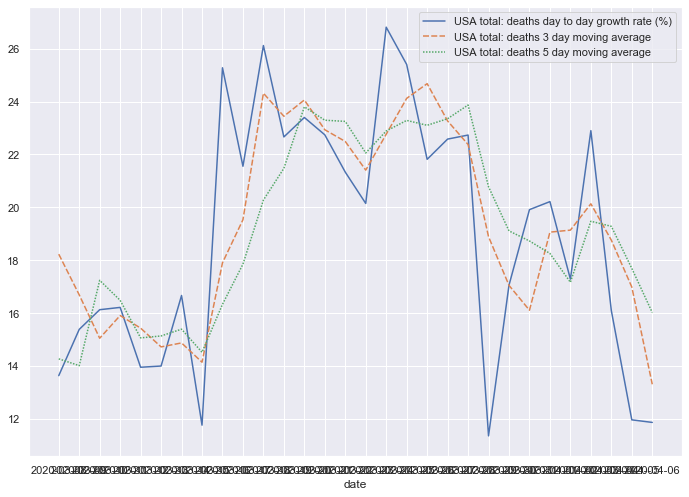

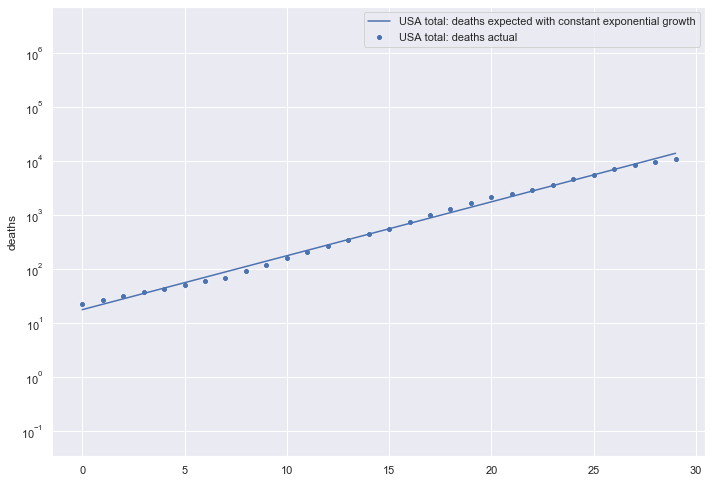

Trajectory plots for USA total:, to see when the curve starts flattening


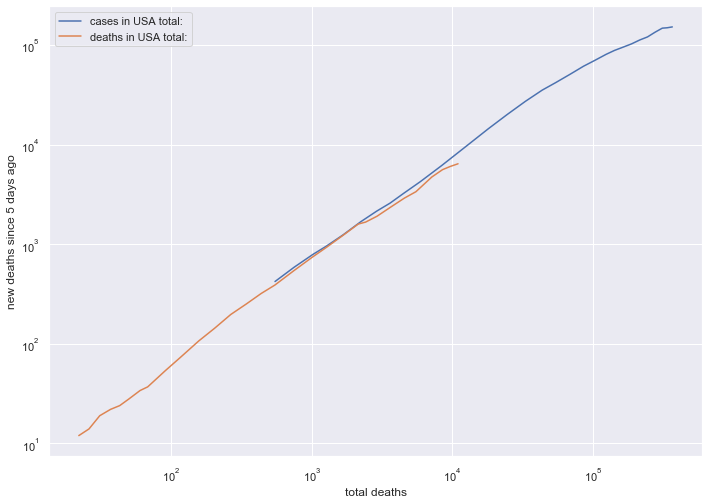

Correlations for USA total::


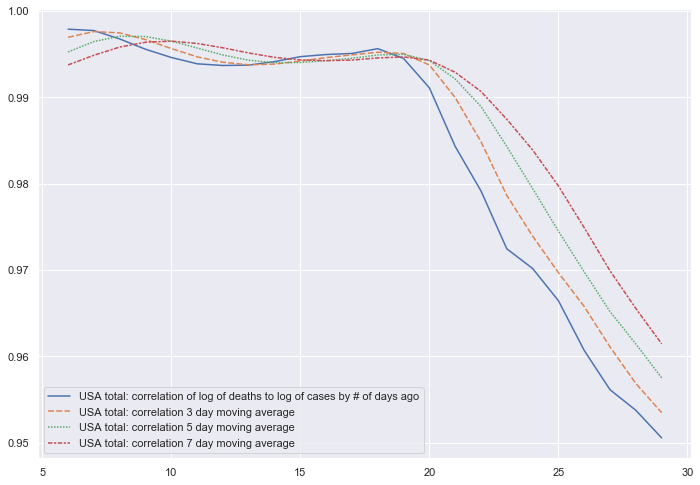

Deaths vs Lagged Values For USA total::


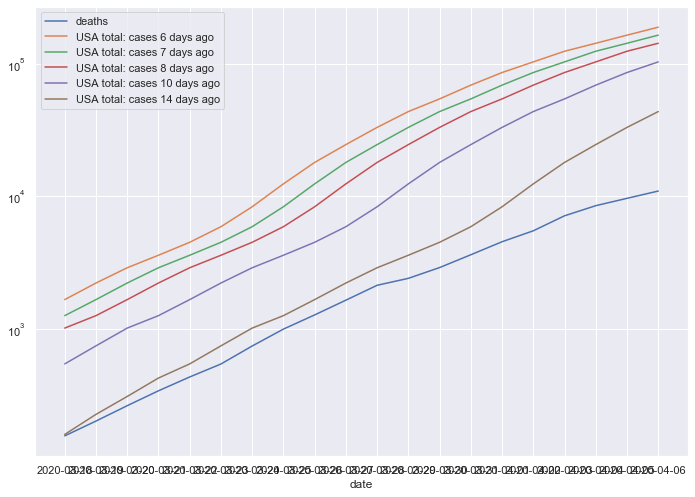

Deaths / Lagged Values For USA total::


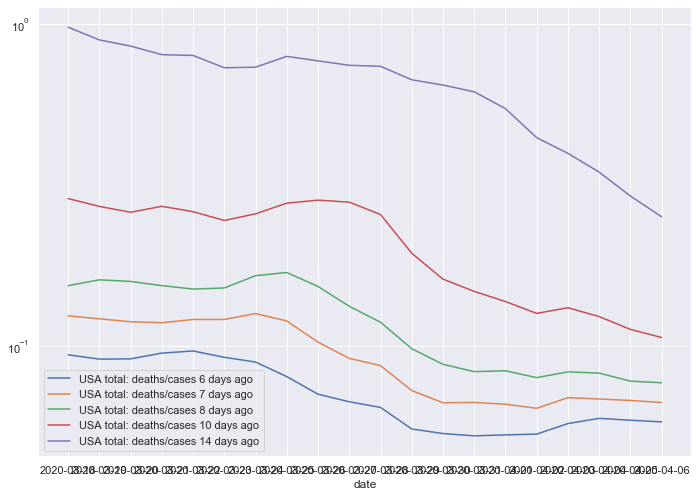

In [14]:
counties =["San Francisco", "Boulder", "Denver", "New York City"]
states = [ "California", "Colorado", "Arizona"]
analyse(counties=counties, states=states)

In [15]:
# counties with the most deaths today
today = rawData.tail(1).date.values[0]
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                               
New York      New York City      0.0  68776    2738
              Unknown            0.0   2091     728
              Nassau         36059.0  15616     535
Michigan      Wayne          26163.0   8270     346
New York      Westchester    36119.0  14293     253
              Suffolk        36103.0  14473     237
Washington    King           53033.0   3333     224
Illinois      Cook           17031.0   8728     209
New Jersey    Bergen         34003.0   6862     200
              Essex          34013.0   4493     186
Michigan      Oakland        26125.0   3380     185
Louisiana     Orleans        22071.0   4565     171
California    Los Angeles     6037.0   6360     147
Louisiana     Jefferson      22051.0   3530     121
Connecticut   Fairfield       9001.0   3719     101
Michigan      Macomb         26099.0   2159     100
New Jersey    Hudson         34017.0   4395      92
              Middlesex      34023.0   3263      87
              Union          34039.0   3685      78
New York      Rockland       36087.0   5703      76
New Jersey    Ocean          34029.0   2374      71
              Monmouth       34025.0   2545      62
              Morris         34027.0   1956      60
Washington    Snohomish      53061.0   1602      57
New Jersey    Passaic        34031.0   3756      53
Florida       Palm Beach     12099.0   1080      51
Massachusetts Middlesex      25017.0   2950      48
New York      Orange         36071.0   3397      47
Florida       Broward        12011.0   2075      47
Wisconsin     Milwaukee      55079.0   1256      45
...                              ...    ...     ...
Missouri      Lincoln        29113.0     18       0
Georgia       Talbot         13263.0      5       0
Missouri      Randolph       29175.0      7       0
              Reynolds       29179.0      2       0
Montana       Hill           30041.0      1       0
Missouri      Ripley         29181.0      2       0
Montana       Glacier        30035.0      1       0
              Gallatin       30031.0    118       0
              Flathead       30029.0     31       0
              Deer Lodge     30023.0      3       0
              Cascade        30013.0     11       0
              Carbon         30009.0      2       0
              Broadwater     30007.0      4       0
              Beaverhead     30001.0      1       0
Missouri      Wright         29229.0      7       0
              Worth          29227.0      1       0
              Webster        29225.0      3       0
              Warren         29219.0      9       0
              Unknown            0.0      2       0
              Taney          29213.0      7       0
              Stone          29209.0      3       0
              Stoddard       29207.0      7       0
Georgia       Screven        13251.0      2       0
              Seminole       13253.0      9       0
Missouri      St. Francois   29187.0     17       0
Georgia       Stephens       13257.0      8       0
Missouri      Shelby         29205.0      1       0
              Scott          29201.0     10       0
              Saline         29195.0      3       0
Wyoming       Washakie       56043.0      4       0

[2497 rows x 3 columns]

In [16]:
# counties with the most cases today
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                               
New York      New York City      0.0  68776    2738
              Unknown            0.0   2091     728
              Nassau         36059.0  15616     535
Michigan      Wayne          26163.0   8270     346
New York      Westchester    36119.0  14293     253
              Suffolk        36103.0  14473     237
Washington    King           53033.0   3333     224
Illinois      Cook           17031.0   8728     209
New Jersey    Bergen         34003.0   6862     200
              Essex          34013.0   4493     186
Michigan      Oakland        26125.0   3380     185
Louisiana     Orleans        22071.0   4565     171
California    Los Angeles     6037.0   6360     147
Louisiana     Jefferson      22051.0   3530     121
Connecticut   Fairfield       9001.0   3719     101
Michigan      Macomb         26099.0   2159     100
New Jersey    Hudson         34017.0   4395      92
              Middlesex      34023.0   3263      87
              Union          34039.0   3685      78
New York      Rockland       36087.0   5703      76
New Jersey    Ocean          34029.0   2374      71
              Monmouth       34025.0   2545      62
              Morris         34027.0   1956      60
Washington    Snohomish      53061.0   1602      57
New Jersey    Passaic        34031.0   3756      53
Florida       Palm Beach     12099.0   1080      51
Massachusetts Middlesex      25017.0   2950      48
New York      Orange         36071.0   3397      47
Florida       Broward        12011.0   2075      47
Wisconsin     Milwaukee      55079.0   1256      45
...                              ...    ...     ...
Missouri      Lincoln        29113.0     18       0
Georgia       Talbot         13263.0      5       0
Missouri      Randolph       29175.0      7       0
              Reynolds       29179.0      2       0
Montana       Hill           30041.0      1       0
Missouri      Ripley         29181.0      2       0
Montana       Glacier        30035.0      1       0
              Gallatin       30031.0    118       0
              Flathead       30029.0     31       0
              Deer Lodge     30023.0      3       0
              Cascade        30013.0     11       0
              Carbon         30009.0      2       0
              Broadwater     30007.0      4       0
              Beaverhead     30001.0      1       0
Missouri      Wright         29229.0      7       0
              Worth          29227.0      1       0
              Webster        29225.0      3       0
              Warren         29219.0      9       0
              Unknown            0.0      2       0
              Taney          29213.0      7       0
              Stone          29209.0      3       0
              Stoddard       29207.0      7       0
Georgia       Screven        13251.0      2       0
              Seminole       13253.0      9       0
Missouri      St. Francois   29187.0     17       0
Georgia       Stephens       13257.0      8       0
Missouri      Shelby         29205.0      1       0
              Scott          29201.0     10       0
              Saline         29195.0      3       0
Wyoming       Washakie       56043.0      4       0

[2497 rows x 3 columns]